# 1D trend with a syntetic example

In this notebook we will demonstrate, with a simple 1D example, how to remove trend from some data and apply *Locally varying mean Kriging*.

## Overall workflow

Once you have detected some deterministic trend in your data, the main steps to apply locally varying mean Kriging are:

1. Fit the deterministic trend with one point estimation method (*RBF* are a good method, but you can also fit using polynomials, ecc.).
2. Remove the deterministic trend from the data and obtain some "residuals".
3. Using the standard procedure of *ordinary Kriging* (experimental variogram, variogram fit, Kriging estimation) on the residuals obtained at the previous step.
4. Sum the results of the ordinary Kriging to obtain your final estimations. 


Now let's see in practice, by also including all the preliminary steps of variogram plotting and so on.  

First of all, let's import some modules

In [1]:
import numpy as np
# (you might need to install ipympl for this)
# %matplotlib widget
import matplotlib.pylab as pl
import gstools as gs
import scipy.interpolate as si

## Load and plot input data

The next step is to import the data, which consist in a file containing two columns: one contains the $x$ coordinate, the other the variable to be interpolated $v$. There is no header, and the file (`samples.txt`) should contain 80 lines.

In [2]:
x, v = np.loadtxt("1D_synt_samples.txt", unpack=True)

**Remember:** even if there are no errors from Python, always check your data. You can check yourself, for example by writing in a `Code` cell the name of the variable and then run the cell.

Another way to quickly check your data is to plot them

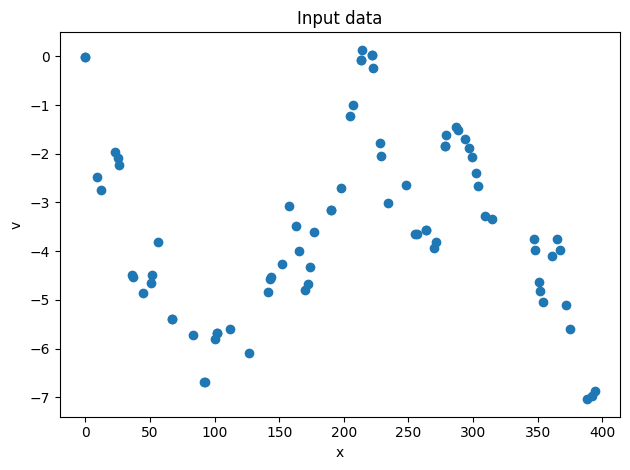

In [3]:
fig, ax = pl.subplots(1,1, num="Input data")
ax.set_title("Input data")
ax.scatter(x,v)
ax.set_xlabel("x")
ax.set_ylabel("v")
pl.tight_layout()

By plotting the data, we can already guess that there will be some deterministic trend to be removed before applying Kriging. Nevertheless, let's try to put this in evidence with an experimental variogram.

## Variogram on $v$

The next step is to compute an experimental variogram and plot it, to check if there is some trend in the data.  
To compute the experimental variogram, you can use `gstools`.

In [4]:
bin_center, gamma, count = gs.vario_estimate((x), v, return_counts=True)

Here we do not provide explicitly the bins to `vario_estimate`, but we set the argument `return_counts` to `True` to return the number of couples used to compute the variogram.

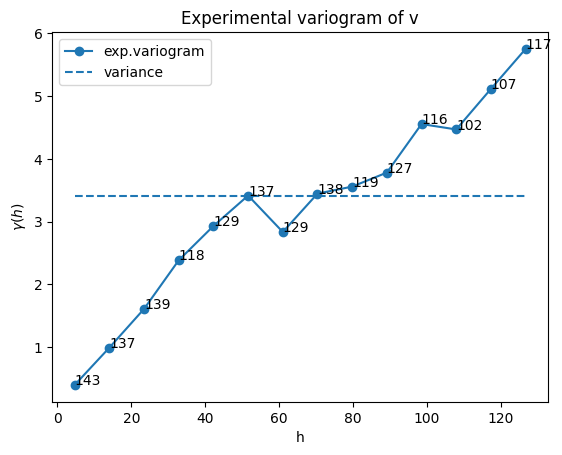

In [5]:
fig, ax = pl.subplots(1,1, num="Experimental variogram on v")
ax.set_title("Experimental variogram of v")
ax.plot(bin_center,gamma, "-o", label="exp.variogram")
for i, c in enumerate(count):
    ax.text(bin_center[i], gamma[i], c)
ax.hlines(np.var(v), xmin=bin_center[0], xmax=bin_center[-1], ls="--",
          label="variance")
ax.set_xlabel("h")
ax.set_ylabel("$\gamma(h)$")
pl.legend()

The variogram on $v$ goes well beyound the variance of the data. We need therefore to model and remove the trend before applying Kriging.

## Fitting the trend with RBFs

As mentioned during the course, Radial Basis Functions (RBFs) are a good tool to interpolate and to eventually be used to remove some deterministic trend from a dataset.

First, we provide the input data (measurements and point locations) to the function `Rbf` to "train" out interpolator.

In [6]:
rbf_trend = si.Rbf(x, v, smooth=20)

Note here that we set the argument `smooth` to a value $>0$. Otherwise, because the RBFs with the default value of smooth (`smooth=0`) are an exact interpolator, there will be no residuals to estimate with Kriging at all.

Once the RBF is "trained" (that is, the weights $w_i$ for the linear combination of radial functions are computed), we can use it to estimate the trend on the 1D grid where we would like to obtain our estimate.  
Note that the reference values are available on a regular grid made of 400 linear cells of size 1 (meter, for example). Therefore, we can create these grid points with `numpy.arange`

In [7]:
x_ref = np.arange(400)

Then, on all the points defined by `x_ref`, we can compute the value of the trend

In [8]:
trend_all = rbf_trend(x_ref)

We can also compute the trend on the same locations where sample measurements are available (the $x$ coordinates): 

In [9]:
trend_sam = rbf_trend(x)

Now we are ready to compute the residuals on our sample locations

In [10]:
res_sam = v-trend_sam

Also, we can plot the RBF trend together with the data

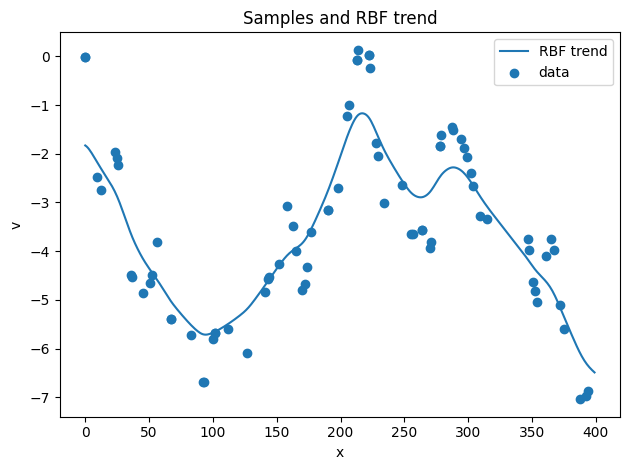

In [11]:
fig, ax = pl.subplots(1,1)
# Plot the samples and the trend
ax.set_title("Samples and RBF trend")
ax.plot(x_ref, trend_all, label="RBF trend")
ax.scatter(x,v, label="data")
ax.set_xlabel("x")
ax.set_ylabel("v")
ax.legend()
# Plot the variogram on the residuals
pl.tight_layout()

If you are not satisfied with the fit of the RBF, you can look at the [corresponding documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html) and try with different input arguments (see also the previous exercise about RBFs).

It is also useful to plot an histogram of the variable $v$, the trend function $m$ and the residuals $r$, together with the corresponding variance

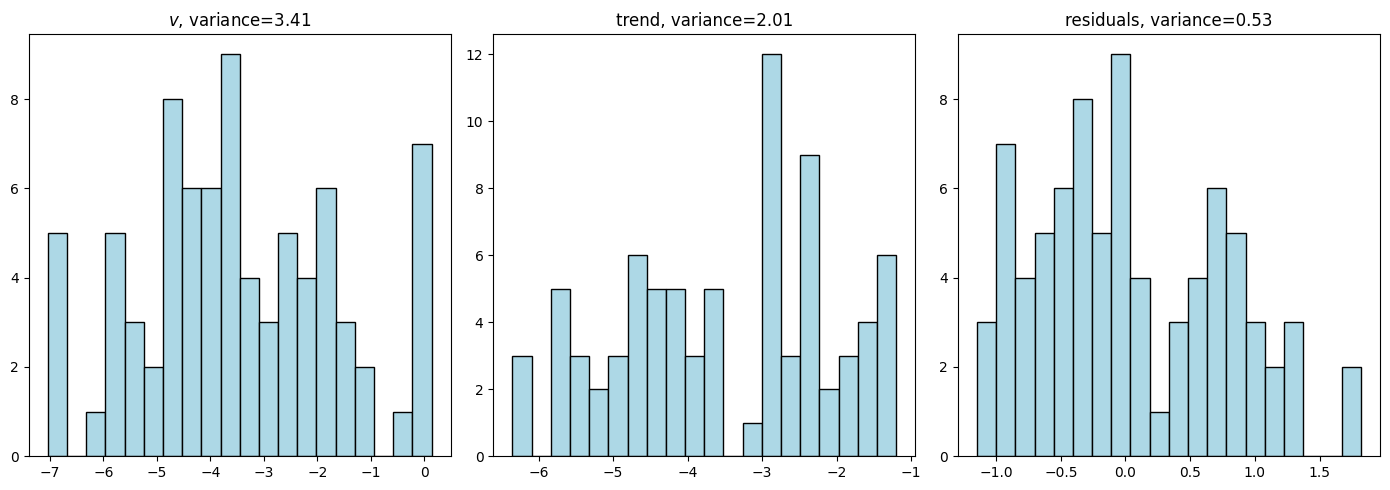

In [12]:
fig, ax = pl.subplots(1,3, figsize=((14,5)), num="Histograms")
# Histogram on v
ax[0].set_title("$v$, variance={0:.2f}".format(np.var(v)))
ax[0].hist(v, 20, color="lightblue", edgecolor="black")
# Histogram on the RBF computed trend
ax[1].set_title("trend, variance={0:.2f}".format(np.var(trend_sam)))
ax[1].hist(trend_sam, 20, color="lightblue", edgecolor="black")
# Histogram on the residuals
ax[2].set_title("residuals, variance={0:.2f}".format(np.var(res_sam)))
ax[2].hist(res_sam, 20, color="lightblue", edgecolor="black")
pl.tight_layout()

From the histograms you can notice how the diverse contributions to the variance of the original variable $v$ given by the residuals and the deterministic trend.

## Experimental variogram of the residuals

It is now important to study the experiemental variogram on the residuals, to double check if the removal of the deterministic trend yielded into an experimental variogram with a clear *sill*.  
This can be done with the following lines.

Here we prefer to explicitly define the bins where the experimental variogram will be computed. Also, for simplicity we do not require the count of the couples used.

In [13]:
bins = np.arange(0,40,1)
bin_center, gamma = gs.vario_estimate((x), res_sam, bins)

To plot the variogram:

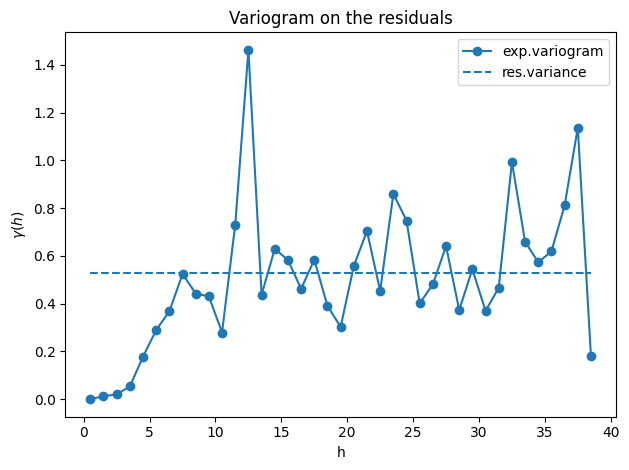

In [14]:
fig, ax = pl.subplots(1,1)
var_res = np.var(res_sam)
ax.set_title("Variogram on the residuals")
ax.plot(bin_center,gamma, "-o", label="exp.variogram")
ax.hlines(np.var(res_sam), xmin=bin_center[0], xmax=bin_center[-1], ls="--",
             label="res.variance")
ax.set_xlabel("h")
ax.set_ylabel("$\gamma(h)$")
ax.legend()
pl.tight_layout()

### Variogram fit

We now see that the experimental variogram on the residuals presents a pretty much clear sill, and that the behaviour at the origing is very close to a Gaussian variogram model. Therefore, we can try to start to fit a variogram of that kind:

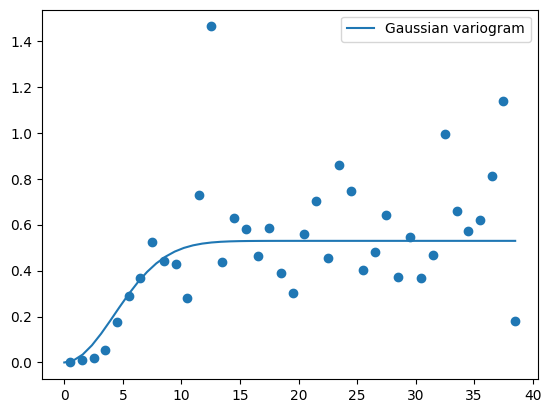

In [17]:
vmod = gs.Gaussian(dim=1, var=var_res)
vmod.fit_variogram(bin_center, gamma, sill=var_res, nugget=False)

# Plot variogram
fig, ax = pl.subplots(1,1, num="Variogram fit")
vmod.plot(ax=ax, x_max=bin_center[-1])
ax.scatter(bin_center, gamma)


## Ordinary Kriging on the residuals

We are now ready to apply ordinary Kriging on the residuals (and plot):

In [ ]:
# Compute the estimator
krig = gs.krige.Ordinary(vmod, cond_pos=[x], cond_val=res_sam)

# Apply the estimator to a regular grid and plot
krig([x_ref], mesh_type="structured")

Before plotting the final result, we can load the reference "true" data to compare them with the results.

In [22]:
x_ref, v_ref = np.loadtxt("1D_synt_ref.txt", unpack=True)

Plot

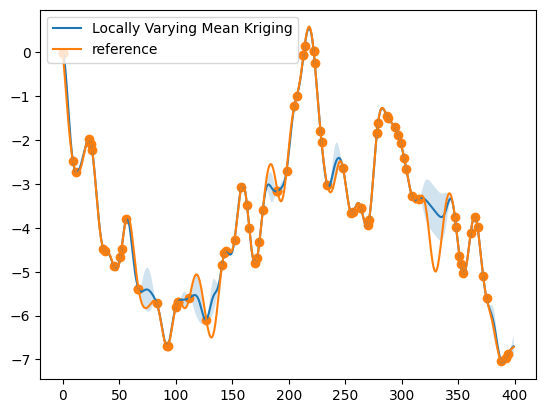

In [25]:
fig, ax = pl.subplots(1,1, num="Kriging results")

ax.plot(x_ref, krig["field"]+trend_all, label="Locally Varying Mean Kriging")
ax.fill_between(x_ref, krig["field"]+trend_all - krig["krige_var"],
                   krig["field"]+trend_all + krig["krige_var"], alpha=0.2)
ax.plot(x_ref, v_ref, label="reference")
ax.scatter(x,v)
pl.legend()

This notebook can be downloaded at the following link: [https://github.com/alecomunian/gmg/blob/main/notebooks/trend/1D_synt.ipynb](https://github.com/alecomunian/gmg/blob/main/notebooks/trend/1D_synt.ipynb).